**Make sure to include** `import allow_local_imports` on top of every notebook in `notebooks/` dir to be able to use `lib/` modules.

In [25]:
# Include this on top, as the first import 
# This must always be imported first. If you are restarting the notebook
# don't forget to run this cell first!
import allow_local_imports

In [26]:
from lib.minority_game import MinorityGame
from lib.agents.agent import Agent, StrategyUpdatingAgent
from lib.agents.factory import AgentFactory
from lib.strategies import AlwaysOneStrategy, DefaultStrategy, FiftyFiftyStrategy
from lib.memory import UniformMemoryGenerator
from lib.plots import default_plot

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma
import seaborn as sns
from numpy.random import default_rng

In [28]:
class BaseMemoryGenerator:
    """
    Abstract class that should be subclassed when implementing
    a new memory generator.
    """
    def __init__(self, m, k):
        self.m = m
        self.k = k # the scale

    def generate(self, size):
        raise NotImplementedError


class UniformMemoryGenerator(BaseMemoryGenerator):
    """
    Samples memory from a uniform distribution.
    (All memories are of equal length...)
    """

    def generate(self, size):
        return np.ones(size, dtype=np.int32) * self.m
    
class NormalDistributionMemoryGenerator(BaseMemoryGenerator):
    """
    Samples memory from a distribution
    (Memories are distributed by normal distribution.)
    """

    def generate(self, size):
        rng = default_rng(0)
        return rng.normal(self.m, 2, size).astype(int)+1
    
class GaussianDistributionMemoryGenerator(BaseMemoryGenerator):
    """
    Samples memory from a distribution
    (Memories are distributed by default gaussian distribution.)
    """

    def generate(self, n_agents, min_m = 1, max_m = 20, a = 4):
        spaces = max_m-min_m+1
        x = np.linspace(min_m, max_m, spaces)
        y =  gamma.pdf(x, a)
        sample = np.random.choice(x, n_agents, p=y/(sum(y))).astype(int)
        return sample

class GumbelDistributionMemoryGenerator(BaseMemoryGenerator):
    """
    Samples memory from a gumbel distribution.
    (Skwed distribution of memory)
    """

    def generate(self, size):
        rng = default_rng(0)
        return rng.gumbel(self.m, self.k, size).astype(int)+1   

## Simple MG (s = 2, N = 101, uniform memory)

In [29]:
n_agents = 101 # check with David why it does not work if I do MinorityGame.n_agents
tot_omega_u = []
tot_alpha_u = []

for M in range (4,10):
    times, attendances, mean_A_t, vol_A_t = MinorityGame(
        n_agents=101,
        factory_dict={
            1: AgentFactory(
                Agent,
                agent_kwargs=dict(
                    strategy_clss=[DefaultStrategy,DefaultStrategy]
                ),
                memory_generator=UniformMemoryGenerator(M, 0)
            ),
        }
    ).simulate_game(max_steps=50000)
    # in order to create the graph
    omega = np.average(vol_A_t)/n_agents
    alpha = 2**M/n_agents
    tot_omega_u.append(omega)
    tot_alpha_u.append(alpha)

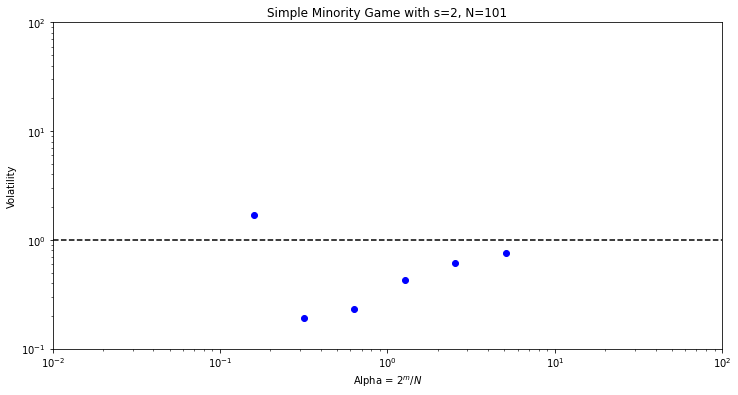

In [30]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.axhline(y=1, color="k", linestyle="--")
ax.plot(tot_alpha_u, tot_omega_u, 'bo')
ax.set_xlabel("Alpha = $2^m/N$")
ax.set_ylabel("Volatility")

plt.title("Simple Minority Game with s=2, N=101")
plt.yscale('log')
plt.xscale('log')
plt.xlim([0.01,100])
plt.ylim([0.1,100])

plt.show()

## MG (s = 2, N = 101, gumbel distribution memory scale = 2)

/Users/Luca/opt/anaconda3/envs/py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


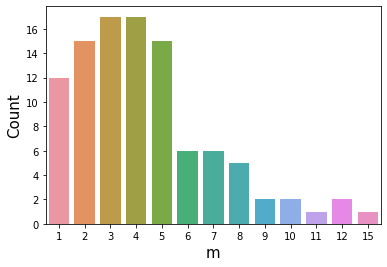

In [31]:
# a possible distribution 
rng = default_rng(0)
m = 3

n_agents = 101

a = rng.gumbel(m, 2, n_agents).astype(int)+1 # m is the mode , 1 is the scale (how narrow it is), n_agents is the size

# Numpy arrays containing counts for each side
side, count = np.unique(a, return_counts=True)

# Plot the results
sns.barplot(side, count)
#plt.title(
    #f"Gumbel distribution of the memory ({n_agents} agents, scale = 2)")
plt.ylabel("Count",fontsize=15)
plt.xlabel("m",fontsize=15)
plt.savefig("out/scale_2.png", dpi = 300)
plt.show()

In [32]:
n_agents = 101 # check with David why it does not work if I do MinorityGame.n_agents
tot_omega_g2 = []
tot_alpha_g2 = []

for M in range (3,10):
    times, attendances, mean_A_t, vol_A_t = MinorityGame(
        n_agents=101,
        factory_dict={
            1: AgentFactory(
                Agent,
                agent_kwargs=dict(
                    strategy_clss=[DefaultStrategy,DefaultStrategy]
                ),
                memory_generator=GumbelDistributionMemoryGenerator(M, 2)
            ),
        }
    ).simulate_game(max_steps=50000)
    # in order to create the graph
    omega = np.average(vol_A_t)/n_agents
    alpha = 2**(M+1)/n_agents
    tot_omega_g2.append(omega)
    tot_alpha_g2.append(alpha)

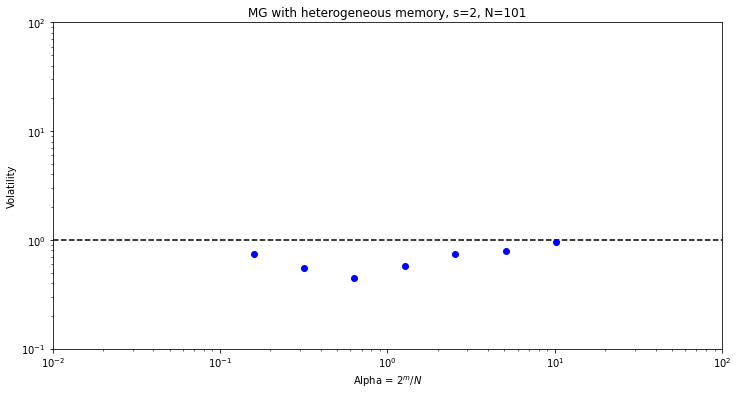

In [33]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.axhline(y=1, color="k", linestyle="--")
ax.plot(tot_alpha_g2, tot_omega_g2, 'bo')
ax.set_xlabel("Alpha = $2^m/N$")
ax.set_ylabel("Volatility")

plt.title("MG with heterogeneous memory, s=2, N=101")
plt.yscale('log')
plt.xscale('log')
plt.xlim([0.01,100])
plt.ylim([0.1,100])

plt.show()

## MG (s = 2, N = 101, gumbel distribution memory scale = 1.5)

/Users/Luca/opt/anaconda3/envs/py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


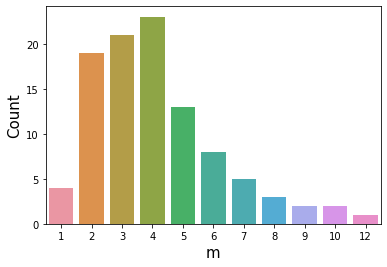

In [34]:
# a possible distribution 
rng = default_rng(0)
m = 3

n_agents = 101

a = rng.gumbel(m, 1.5, n_agents).astype(int)+1 # m is the mode , 1 is the scale (how narrow it is), n_agents is the size

# Numpy arrays containing counts for each side
side, count = np.unique(a, return_counts=True)

# Plot the results
sns.barplot(side, count)
#plt.title(
 #   f"Gumbel distribution of the memory ({n_agents} agents, scale = 1.5)")
plt.ylabel("Count", fontsize=15)
plt.xlabel("m", fontsize=15)
plt.savefig("out/scale_1_5.png", dpi = 300)
plt.show()

In [35]:
n_agents = 101 # check with David why it does not work if I do MinorityGame.n_agents
tot_omega_g1_5 = []
tot_alpha_g1_5 = []

for M in range (3,10):
    times, attendances, mean_A_t, vol_A_t = MinorityGame(
        n_agents=101,
        factory_dict={
            1: AgentFactory(
                Agent,
                agent_kwargs=dict(
                    strategy_clss=[DefaultStrategy,DefaultStrategy]
                ),
                memory_generator=GumbelDistributionMemoryGenerator(M, 1.5)
            ),
        }
    ).simulate_game(max_steps=50000)
    # in order to create the graph
    omega = np.average(vol_A_t)/n_agents
    alpha = 2**(M+1)/n_agents
    tot_omega_g1_5.append(omega)
    tot_alpha_g1_5.append(alpha)

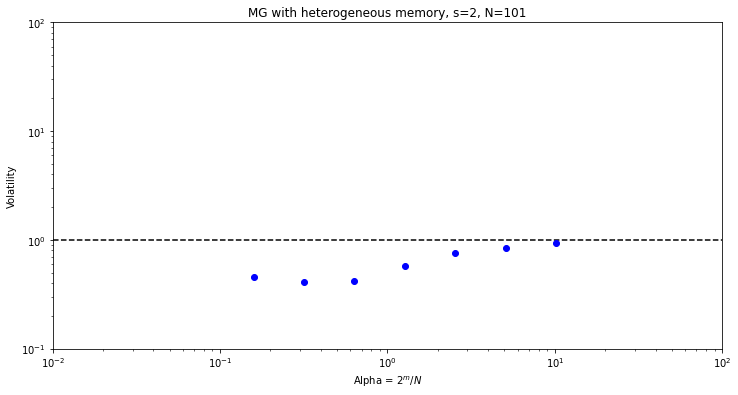

In [36]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.axhline(y=1, color="k", linestyle="--")
ax.plot(tot_alpha_g1_5, tot_omega_g1_5, 'bo')
ax.set_xlabel("Alpha = $2^m/N$")
ax.set_ylabel("Volatility")

plt.title("MG with heterogeneous memory, s=2, N=101")
plt.yscale('log')
plt.xscale('log')
plt.xlim([0.01,100])
plt.ylim([0.1,100])

plt.show()

## MG (s = 2, N = 101, gumbel distribution memory scale = 1)

/Users/Luca/opt/anaconda3/envs/py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


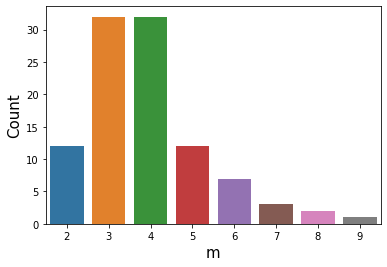

In [37]:
# a possible distribution 
rng = default_rng(0)
m = 3

n_agents = 101

a = rng.gumbel(m, 1, n_agents).astype(int)+1 # m is the mode , 1 is the scale (how narrow it is), n_agents is the size

# Numpy arrays containing counts for each side
side, count = np.unique(a, return_counts=True)

# Plot the results
sns.barplot(side, count)
#plt.title(
 #   f"Gumbel distribution of the memory ({n_agents} agents, scale = 1)")
plt.ylabel("Count",fontsize=15)
plt.xlabel("m",fontsize=15)
plt.savefig("out/scale_1.png", dpi = 300)
plt.show()

In [38]:
n_agents = 101 # check with David why it does not work if I do MinorityGame.n_agents
tot_omega_g1 = []
tot_alpha_g1 = []

for M in range (3,10):
    times, attendances, mean_A_t, vol_A_t = MinorityGame(
        n_agents=101,
        factory_dict={
            1: AgentFactory(
                Agent,
                agent_kwargs=dict(
                    strategy_clss=[DefaultStrategy,DefaultStrategy]
                ),
                memory_generator=GumbelDistributionMemoryGenerator(M, 1)
            ),
        }
    ).simulate_game(max_steps=50000)
    # in order to create the graph
    omega = np.average(vol_A_t)/n_agents
    alpha = 2**(M+1)/n_agents
    tot_omega_g1.append(omega)
    tot_alpha_g1.append(alpha)

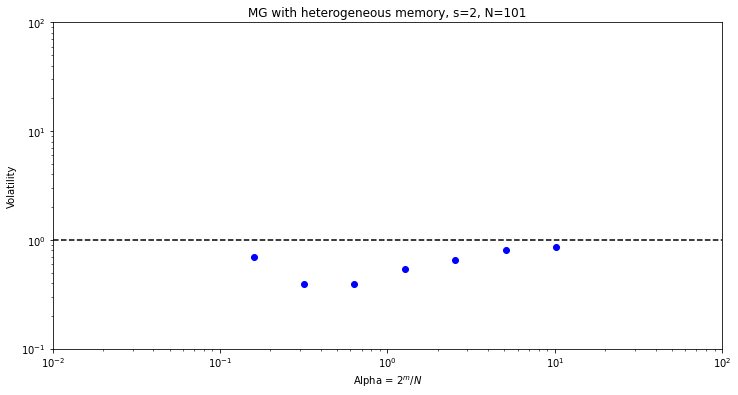

In [39]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.axhline(y=1, color="k", linestyle="--")
ax.plot(tot_alpha_g1, tot_omega_g1, 'bo')
ax.set_xlabel("Alpha = $2^m/N$")
ax.set_ylabel("Volatility")

plt.title("MG with heterogeneous memory, s=2, N=101")
plt.yscale('log')
plt.xscale('log')
plt.xlim([0.01,100])
plt.ylim([0.1,100])

plt.show()

## MG (s = 2, N = 101, gumbel distribution memory scale = 0.5)

/Users/Luca/opt/anaconda3/envs/py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


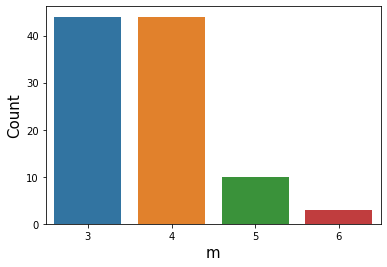

In [40]:
# a possible distribution 
rng = default_rng(0)
m = 3

n_agents = 101

a = rng.gumbel(m, 0.5, n_agents).astype(int)+1 # m is the mode , 1 is the scale (how narrow it is), n_agents is the size

# Numpy arrays containing counts for each side
side, count = np.unique(a, return_counts=True)

# Plot the results
sns.barplot(side, count)
#plt.title(
 #   f"Gumbel distribution of the memory ({n_agents} agents, scale = 0.5)")
plt.ylabel("Count",fontsize=15)
plt.xlabel("m",fontsize=15)
plt.savefig("out/scale_0_5.png", dpi = 300)
plt.show()

In [41]:
n_agents = 101 # check with David why it does not work if I do MinorityGame.n_agents
tot_omega_g0_5 = []
tot_alpha_g0_5 = []

for M in range (3,10):
    times, attendances, mean_A_t, vol_A_t = MinorityGame(
        n_agents=101,
        factory_dict={
            1: AgentFactory(
                Agent,
                agent_kwargs=dict(
                    strategy_clss=[DefaultStrategy,DefaultStrategy]
                ),
                memory_generator=GumbelDistributionMemoryGenerator(M, 0.5)
            ),
        }
    ).simulate_game(max_steps=50000)
    # in order to create the graph
    omega = np.average(vol_A_t)/n_agents
    alpha = 2**(M+1)/n_agents
    tot_omega_g0_5.append(omega)
    tot_alpha_g0_5.append(alpha)

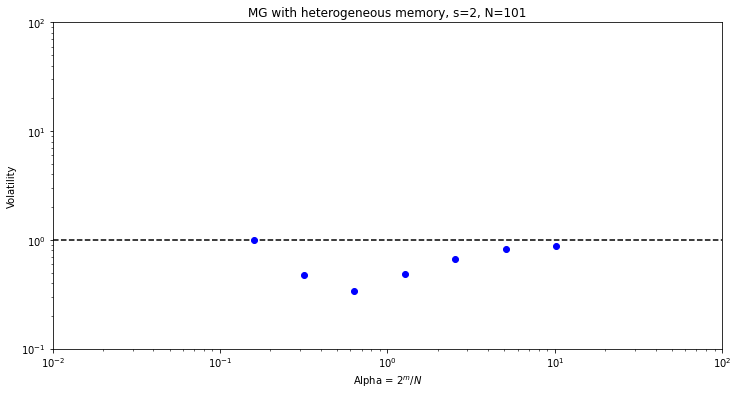

In [42]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.axhline(y=1, color="k", linestyle="--")
ax.plot(tot_alpha_g0_5, tot_omega_g0_5, 'bo')
ax.set_xlabel("Alpha = $2^m/N$")
ax.set_ylabel("Volatility")

plt.title("MG with heterogeneous memory, s=2, N=101")
plt.yscale('log')
plt.xscale('log')
plt.xlim([0.01,100])
plt.ylim([0.1,100])

plt.show()

## Everything in one graph

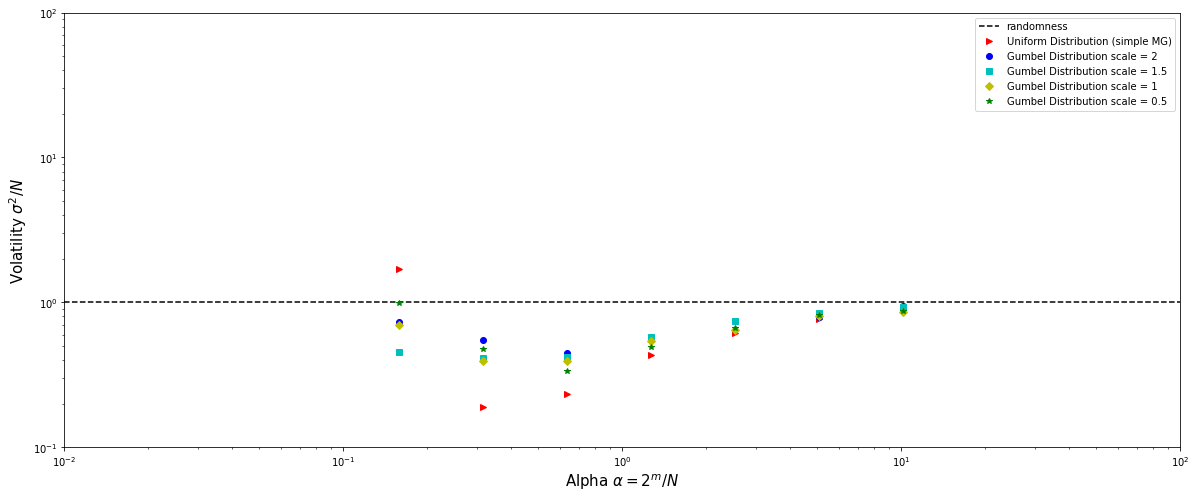

In [43]:
# everything in one graph

fig, ax = plt.subplots(figsize=(20, 8))

ax.axhline(y=1, color="k", linestyle="--") # vol = 1 -> randomness

ax.plot(tot_alpha_u, tot_omega_u, '>r')
ax.plot(tot_alpha_g2, tot_omega_g2, 'bo')
ax.plot(tot_alpha_g1_5, tot_omega_g1_5, 'sc')
ax.plot(tot_alpha_g1, tot_omega_g1, 'Dy')
ax.plot(tot_alpha_g0_5, tot_omega_g0_5, '*g')

ax.set_xlabel(r"Alpha $\alpha = 2^m/N$", fontsize=15)
ax.set_ylabel("Volatility $\sigma^2/N$", fontsize=15)

ax.legend(["randomness","Uniform Distribution (simple MG)",
           "Gumbel Distribution scale = 2", 
           "Gumbel Distribution scale = 1.5", 
           "Gumbel Distribution scale = 1", 
           "Gumbel Distribution scale = 0.5"])

#plt.title("Volatilty as a function of alpha (MG with s=2, N=101)")
plt.yscale('log')
plt.xscale('log')
plt.xlim([0.01,100])
plt.ylim([0.1,100])

plt.savefig("out/diff_level_hetero.png", dpi = 300)
plt.show()